In [15]:
import os

import analysis_utils as utils

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", 
          "#beb9db", "#fdcce5", "#8bd3c7"]
continuous_colors = ["#54bebe", "#76c8c8", "#98d1d1", "#badbdb", "#dedad2", 
                     "#e4bcad", "#df979e", "#d7658b", "#c80064"]
custom_palette = {'l': colors[1], 's': colors[0]}

In [17]:
cohort = 'cohort_1'
to_analyze = 'full_clean'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
figure_folder = os.path.join(data_dir, cohort, 'figures')
data_folder = os.path.join(data_dir, cohort, to_analyze)
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_1/full_clean
/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_1/figures


## load session log

In [18]:
training_session_log = utils.load_session_log(data_folder, 'training_sessions.csv')

In [19]:
training_session_log.describe()

,index,num_blocks,num_trials,rewards,time,days
count,45.000000,45.0,45.000000,45.000000,45.000000,45.000000
mean,22.000000,3.0,241.711111,372.659333,2397.683556,5.133333
std,13.133926,0.0,17.039556,157.169553,479.464477,3.286335
min,0.000000,3.0,190.000000,143.730000,1720.980000,0.000000
25%,11.000000,3.0,234.000000,245.950000,2101.570000,2.000000
50%,22.000000,3.0,245.000000,331.380000,2214.960000,5.000000
75%,33.000000,3.0,251.000000,505.390000,2733.470000,8.000000
max,44.000000,3.0,277.000000,686.620000,3622.290000,11.000000


In [10]:
training_session_log.time.sum()

107895.76

In [13]:
107895.76 / 60 

1798.2626666666665

make mouse list

In [105]:
mouse_list = utils.generate_mouse_list(training_session_log)

['RZ008', 'RZ009', 'RZ010', 'RZ011']


In [106]:
def plot_each_mouse_per_line(data_df, column_name, plot_name, title, x_label, y_label, 
                             figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    for i, mouse in enumerate(mouse_list):
        session_mouse = data_df.loc[data_df.mouse == mouse]
        plt.plot(session_mouse.days, session_mouse[column_name], color=colors[i], label=mouse)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [107]:
def plot_overdays_colored_by_group(data_df, column_name, plot_name, title, x_label, y_label, 
                                   figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    sns.lineplot(x="days",
                 y=column_name,
                 data=data_df)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [108]:
def plot_overdays_l_vs_s(data_df, y1, y2, plot_name, title, y_label):
    fig = plt.figure()
    sns.lineplot(x="days", y=y1, data=data_df, color=custom_palette['l'], label='l')
    sns.lineplot(x="days", y=y2, data=data_df, color=custom_palette['s'], label='s')
    plt.title(title)
    plt.xlabel('Days in Training')
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

## Plot type of trials per session

load analyzed all trials

In [25]:
def get_session_performance(all_trials):
    num_miss_trials = all_trials.miss_trial.sum()
    good_trials = all_trials.loc[(all_trials['miss_trial'] == False) & (all_trials['background_repeats'] == 1)]
    num_good_trials = len(good_trials)
    return [num_miss_trials, num_good_trials]

In [26]:
def generate_trial_type_df(training_session_log):
    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        session_performance = get_session_performance(all_trials)
        training_session_log.loc[training_session_log.dir == dir_name, 
                                 ['miss_trials', 'good_trials']] = session_performance
    trial_type_df = training_session_log[['mouse', 'days', 'num_trials', 'miss_trials', 'good_trials']].copy()
    trial_type_df['p_miss'] = trial_type_df.miss_trials/trial_type_df.num_trials
    trial_type_df['p_good'] = trial_type_df.good_trials/trial_type_df.num_trials
    trial_type_df['p_bg_repeats'] = 1 - trial_type_df.p_good - trial_type_df.p_miss 
    return trial_type_df

In [27]:
trial_type_df = generate_trial_type_df(training_session_log)

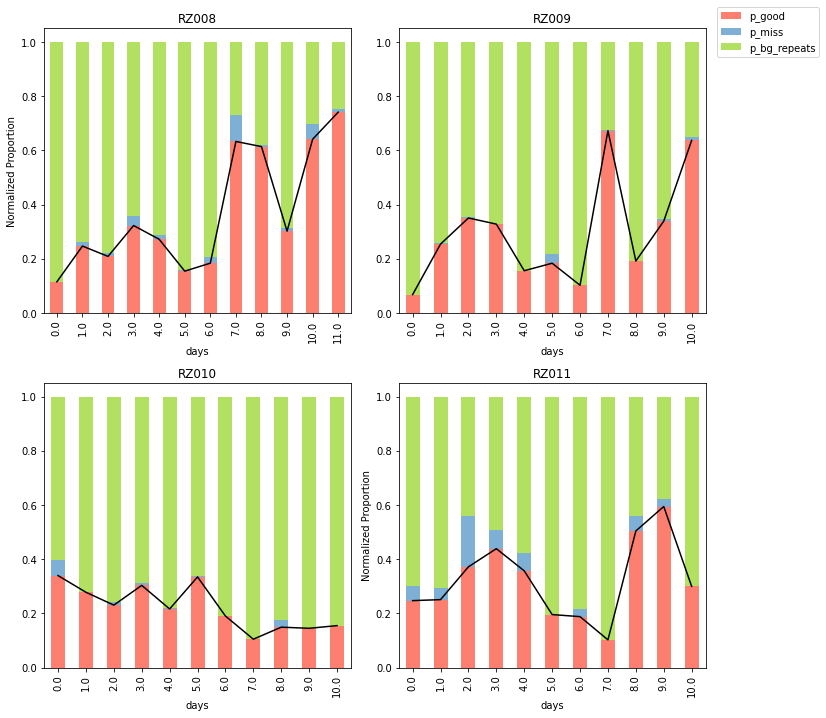

In [28]:
# ploting the proportion of good trials, miss trials, and enl trials per session
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = trial_type_df.loc[trial_type_df.mouse == mouse]
    to_plot = session_mouse.loc[:, ['days', 'p_good', 'p_miss', 'p_bg_repeats']]
    ax = axs.flat[i]
    to_plot.plot.bar(x='days', stacked=True, color=colors[0:3], ax=ax, legend=None)
    ax.set_title(mouse)
    if i == 0 or i == 3:
        ax.set_ylabel('Normalized Proportion')
    ax.plot(to_plot.days, to_plot.p_good, color='k', linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.savefig(f'{figure_folder}/engagement_plots.png', bbox_inches='tight')
plt.show()

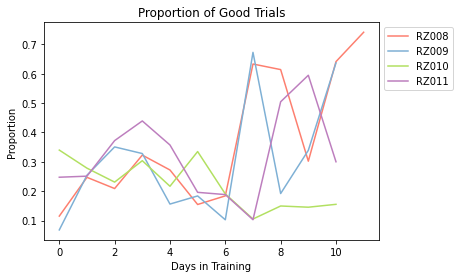

In [29]:
# plot the proportion of good trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_good', 
                         plot_name="%_good_trials", 
                         title='Proportion of Good Trials',
                         x_label='Days in Training', 
                         y_label='Proportion')

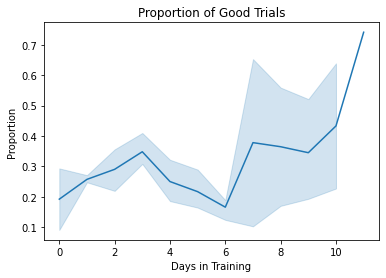

In [30]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_good", 
                               plot_name='%_good_trials_by_group', 
                               title='Proportion of Good Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

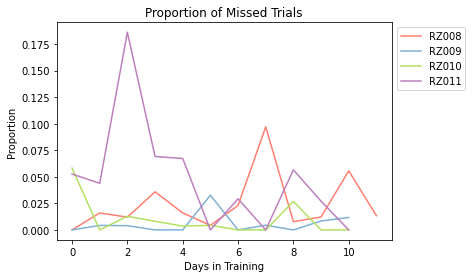

In [31]:
# plot the proportion of miss trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_miss', 
                         plot_name="%_miss_trials",
                         title='Proportion of Missed Trials', 
                         x_label='Days in Training', 
                         y_label='Proportion')

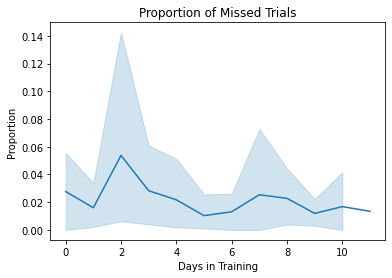

In [32]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_miss", 
                               plot_name='%_miss_trials_by_group', 
                               title='Proportion of Missed Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

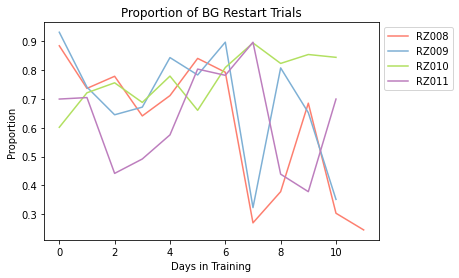

In [92]:
# plot the proportion of accident trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_bg_repeats', 
                         plot_name="%_accident_trials", 
                         title='Proportion of BG Restart Trials',
                         x_label='Days in Training', 
                         y_label='Proportion')

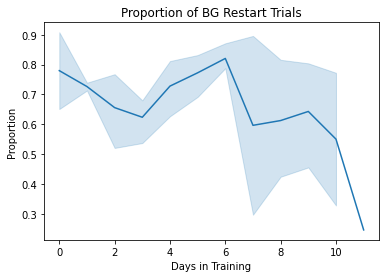

In [93]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_bg_repeats", 
                               plot_name='%_accident_trials_by_group', 
                               title='Proportion of BG Restart Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

## Plot mistakes per session

In [35]:
def get_session_mistakes(all_trials):
    num_bg_repeats_mean = all_trials.background_repeats.mean()
    num_bg_repeats_med = all_trials.background_repeats.median()
    num_bg_repeats_std = all_trials.background_repeats.std()
    return [num_bg_repeats_mean, num_bg_repeats_med, num_bg_repeats_std]

In [36]:
def get_blk_mistakes(all_trials):
    enl_list = []
    blk_type_list = ['l', 's']
    for blk_type in blk_type_list: 
        blk = all_trials.loc[all_trials['blk_type']==blk_type]
        enl_list.append(blk.background_repeats.mean())
        enl_list.append(blk.background_repeats.median())
        enl_list.append(blk.background_repeats.std())
    return enl_list

In [37]:
def generate_mistake_df(training_session_log):
    mistake_df = training_session_log[['mouse', 'days', 'dir']]

    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        session_mistakes = get_session_mistakes(all_trials)
        mistake_df.loc[mistake_df.dir == dir_name, 
                                ['num_bg_repeats_mean', 'num_bg_repeats_median', 
                                'num_bg_repeats_stdev']] = session_mistakes
        
        block_mistakes = get_blk_mistakes(all_trials)
        mistake_df.loc[mistake_df.dir == dir_name, 
                                    ['bg_l_mean', 'bg_l_median', 'bg_l_stdev',
                                     'bg_s_mean', 'bg_s_median','bg_s_stdev']] = block_mistakes
    
    return mistake_df

In [38]:
mistake_df = generate_mistake_df(training_session_log)

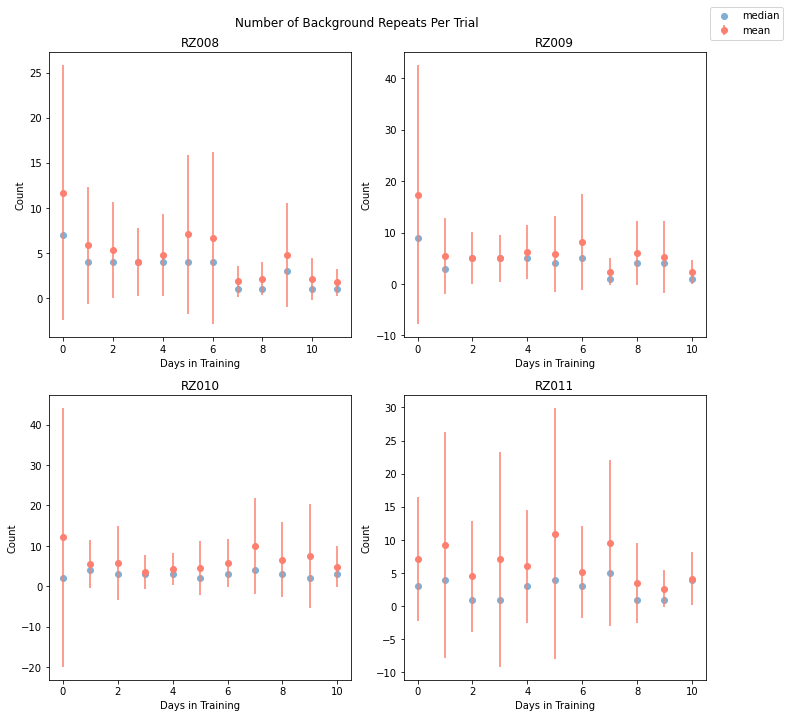

In [97]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = mistake_df.loc[mistake_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.days, session_mouse.num_bg_repeats_mean, session_mouse.num_bg_repeats_stdev, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.days, session_mouse.num_bg_repeats_median, color=colors[1], label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Count')

# Extract the legend from the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()

# Set the figure legend outside the loop
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
fig.suptitle('Number of Background Repeats Per Trial')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/_repeats_plots.png', bbox_inches='tight', dpi=300)

# Show the plot (optional)
plt.show()

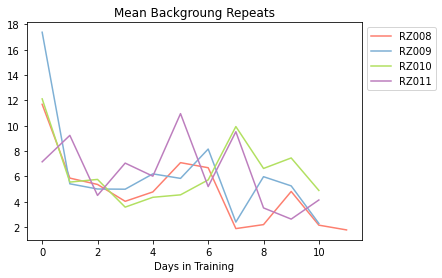

In [40]:
# plot the mean ENL repeats
plot_each_mouse_per_line(data_df=mistake_df, 
                         column_name='num_bg_repeats_mean', 
                         plot_name='bg_repeats_mean',
                         title='Mean Backgroung Repeats', 
                         x_label='Days in Training', 
                         y_label='')

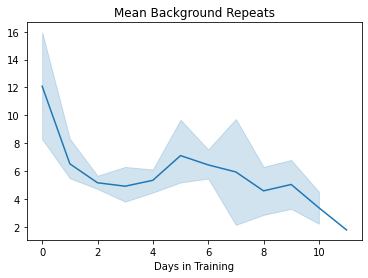

In [41]:
plot_overdays_colored_by_group(data_df=mistake_df, 
                               column_name="num_bg_repeats_mean", 
                               plot_name='bg_repeats_mean_by_group', 
                               title='Mean Background Repeats', 
                               x_label='Days in Training', 
                               y_label='')

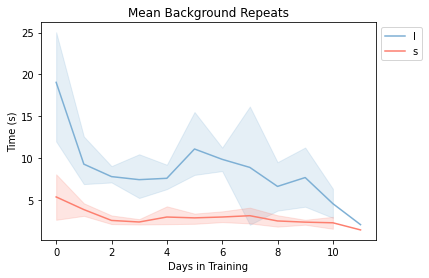

In [42]:
plot_overdays_l_vs_s(data_df = mistake_df, 
                     y1='bg_l_mean', 
                     y2='bg_s_mean', 
                     plot_name='bg_s_l', 
                     title='Mean Background Repeats', 
                     y_label='Time (s)')

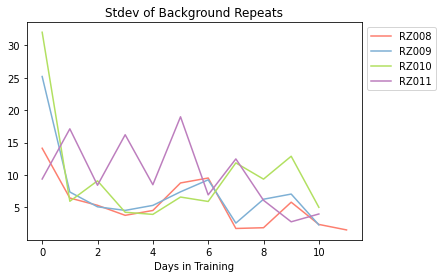

In [43]:
# plot the stdev ENL repeats
plot_each_mouse_per_line(data_df=mistake_df, 
                         column_name='num_bg_repeats_stdev', 
                         plot_name='bg_repeats_stdev',
                         title='Stdev of Background Repeats', 
                         x_label='Days in Training', 
                         y_label='')

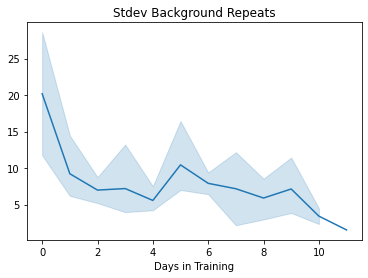

In [44]:
plot_overdays_colored_by_group(data_df=mistake_df, 
                               column_name="num_bg_repeats_stdev", 
                               plot_name='bg_repeats_stdev_by_group', 
                               title='Stdev Background Repeats', 
                               x_label='Days in Training', 
                               y_label='')

## Plot rewards per session

In [109]:
training_session_log['reward_rate'] = training_session_log.rewards/training_session_log.time

In [110]:
training_session_log['reward_per_trial'] = training_session_log.rewards/training_session_log.num_trials

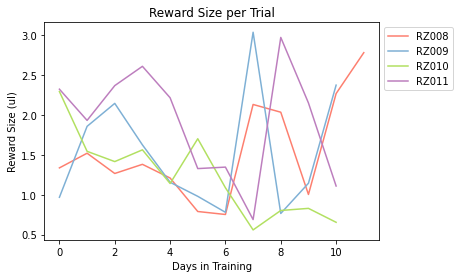

In [47]:
# plot the reward rize
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_per_trial', 
                         plot_name="reward_size",
                         title='Reward Size per Trial', 
                         x_label='Days in Training', 
                         y_label='Reward Size (ul)')

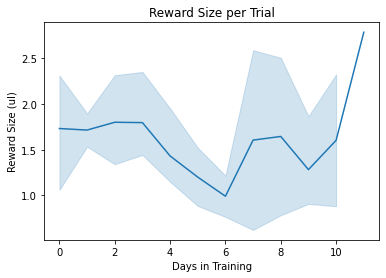

In [48]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_per_trial", 
                               plot_name='reward_size_by_group', 
                               title='Reward Size per Trial', 
                               x_label='Days in Training', 
                               y_label='Reward Size (ul)')

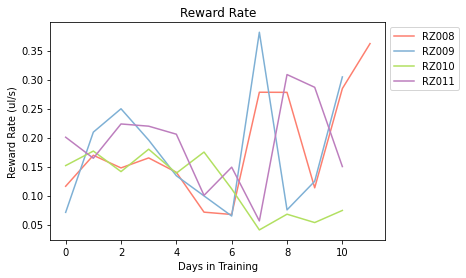

In [49]:
# plot the reward rate
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_rate', 
                         plot_name="reward_rate",
                         title='Reward Rate', 
                         x_label='Days in Training', 
                         y_label='Reward Rate (ul/s)')

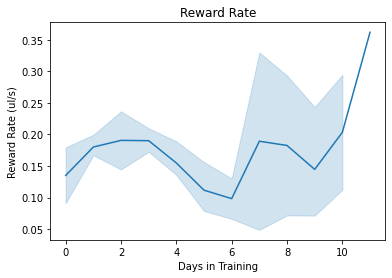

In [111]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_rate", 
                               plot_name='reward_rate_by_group', 
                               title='Reward Rate', 
                               x_label='Days in Training', 
                               y_label='Reward Rate (ul/s)')

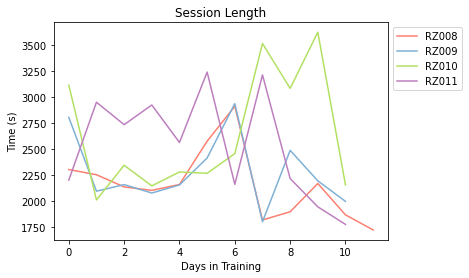

In [51]:
# plot the session length
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='time', 
                         plot_name="session_length", 
                         title='Session Length',
                         x_label='Days in Training', 
                         y_label='Time (s)')

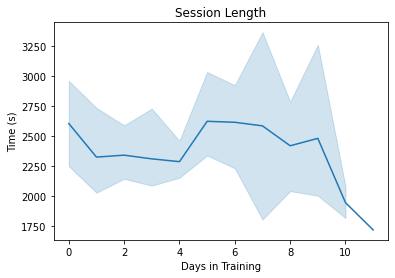

In [52]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="time", 
                               plot_name='session_length_by_group', 
                               title='Session Length', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

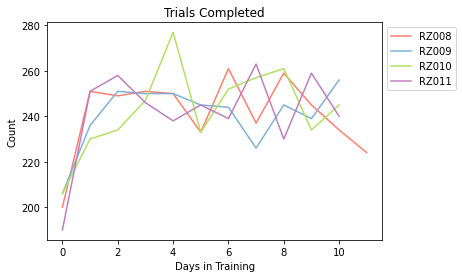

In [53]:
# plot the number of trials completed
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='num_trials', 
                         plot_name="num_trials", 
                         title='Trials Completed',
                         x_label='Days in Training', 
                         y_label='Count')

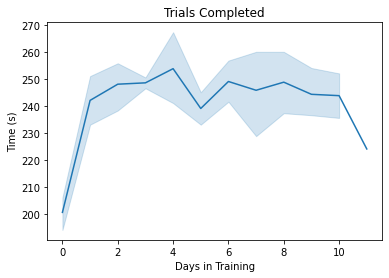

In [54]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="num_trials", 
                               plot_name='num_trials_by_group', 
                               title='Trials Completed', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

## Plot time wait behavior

In [21]:
def get_session_tw(all_trials):
    tw_mean = all_trials.time_waited.mean()
    tw_med = all_trials.time_waited.median()
    tw_std = all_trials.time_waited.std()
    return [tw_mean, tw_med, tw_std]

In [22]:
def get_block_tw(all_trials):
    tw_list = []
    blk_type_list = ['l', 's']
    for blk_type in blk_type_list: 
        blk = all_trials.loc[all_trials['blk_type']==blk_type]
        tw_list.append(blk.time_waited.mean())
        tw_list.append(blk.time_waited.median())
        tw_list.append(blk.time_waited.std())
    return tw_list


In [23]:
def select_good_trials(all_trials):
    good_trials = all_trials.loc[(all_trials.miss_trial == False) & (all_trials.background_repeats == 1)]
    return good_trials

In [24]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'days', 'dir']].copy()

    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        # time waited for all trials
        session_tw = get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw
        # time waited for long and short blocks
        block_tw = get_block_tw(all_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_l_mean', 'tw_l_median', 'tw_l_stdev',
                                'tw_s_mean', 'tw_s_median','tw_s_stdev']] = block_tw

        good_trials = select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
        block_tw_g = get_block_tw(good_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_l_mean_g', 'tw_l_median_g', 'tw_l_stdev_g',
                                'tw_s_mean_g', 'tw_s_median_g','tw_s_stdev_g']] = block_tw_g

    wait_df['tw_diff'] = wait_df['tw_l_mean'] - wait_df['tw_s_mean']
    wait_df['tw_diff_g'] = wait_df['tw_l_mean_g'] - wait_df['tw_s_mean_g']
    return wait_df

In [25]:
wait_df = generate_wait_df(training_session_log)
utils.save_log(wait_df, data_folder, 'wait.csv')

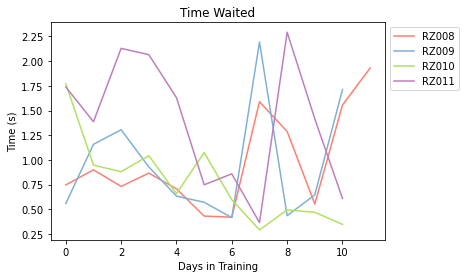

In [60]:
# plot the time waited over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean', 
                         plot_name="tw_mean", 
                         title='Time Waited',
                         x_label='Days in Training', 
                         y_label='Time (s)')

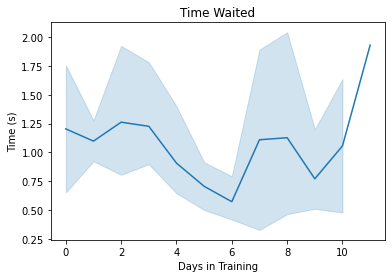

In [61]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean", 
                               plot_name='tw_mean_by_group', 
                               title='Time Waited', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

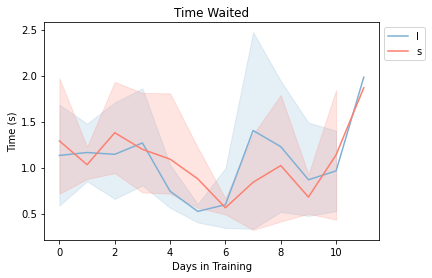

In [62]:
plot_overdays_l_vs_s(data_df = wait_df, 
                     y1='tw_l_mean', 
                     y2='tw_s_mean', 
                     plot_name='tw_s_l', 
                     title='Time Waited', 
                     y_label='Time (s)')

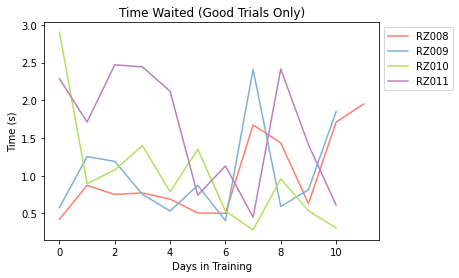

In [63]:
# plot the time waited over days good trials only. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean_g', 
                         plot_name="tw_mean_g", 
                         title='Time Waited (Good Trials Only)',
                         x_label='Days in Training', 
                         y_label='Time (s)')

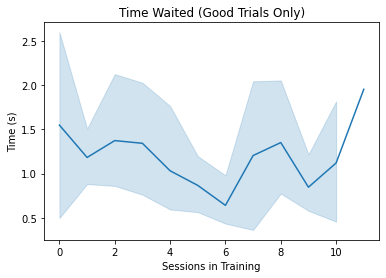

In [64]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean_g", 
                               plot_name='tw_mean_g_by_group', 
                               title='Time Waited (Good Trials Only)', 
                               x_label='Sessions in Training', 
                               y_label='Time (s)')

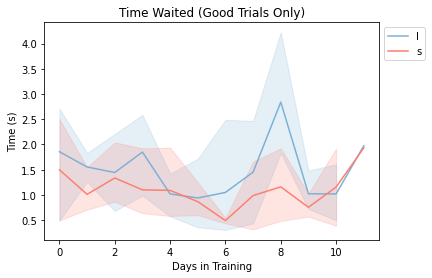

In [65]:
plot_overdays_l_vs_s(data_df = wait_df, 
                     y1='tw_l_mean_g', 
                     y2='tw_s_mean_g', 
                     plot_name='tw_s_l_g', 
                     title='Time Waited (Good Trials Only)', 
                     y_label='Time (s)')

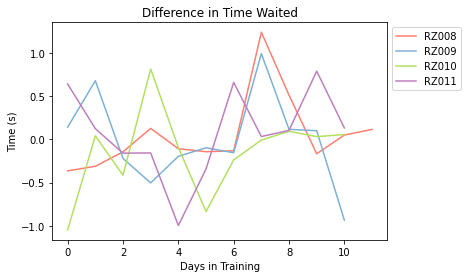

In [66]:
# plot the difference in time waited bewteen long and short blocks over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_diff', 
                         plot_name="tw_diff", 
                         title='Difference in Time Waited',
                         x_label='Days in Training', 
                         y_label='Time (s)')

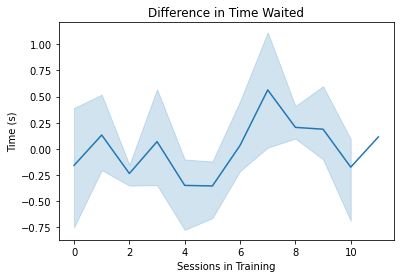

In [67]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_diff", 
                               plot_name='tw_diff_by_group', 
                               title='Difference in Time Waited', 
                               x_label='Sessions in Training', 
                               y_label='Time (s)')

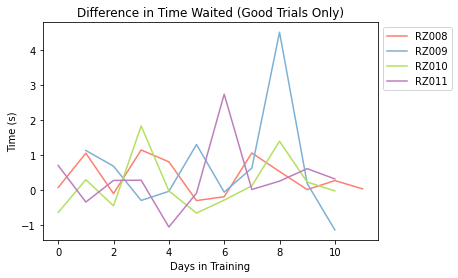

In [68]:
# plot the difference in time waited bewteen long and short blocks over days. good trials only
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_diff_g', 
                         plot_name="tw_diff_g", 
                         title='Difference in Time Waited (Good Trials Only)',
                         x_label='Days in Training', 
                         y_label='Time (s)')

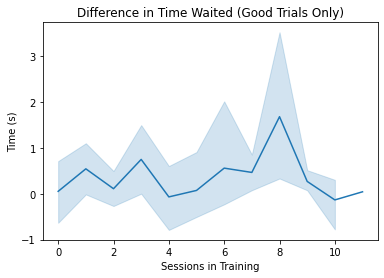

In [69]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_diff_g", 
                               plot_name='tw_diff_g_by_group', 
                               title='Difference in Time Waited (Good Trials Only)', 
                               x_label='Sessions in Training', 
                               y_label='Time (s)')

In [70]:
def generate_linear_fit_df(training_session_log):
    linear_fit_df = training_session_log[['mouse', 'days', 'dir']].copy()
    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        all_trials = all_trials[all_trials['time_waited'].notna()]
        fit_data = utils.linear_fit(all_trials, 'bg_length', 'time_waited')
        linear_fit_df.loc[linear_fit_df.dir == dir_name, 
                                ['slope', 'intercept', 'rsquared']] = fit_data
    return linear_fit_df

In [71]:
linear_fit_df = generate_linear_fit_df(training_session_log)

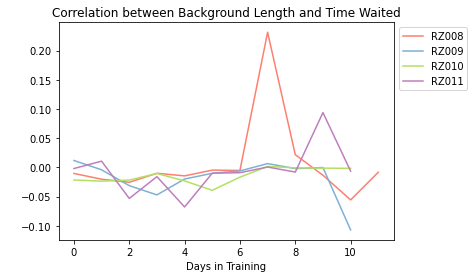

In [72]:
# plot the difference in time waited bewteen long and short blocks over days. good trials only
plot_each_mouse_per_line(data_df=linear_fit_df, 
                         column_name='slope', 
                         plot_name="tb_tw_correlation", 
                         title='Correlation between Background Length and Time Waited',
                         x_label='Days in Training', 
                         y_label=' ')

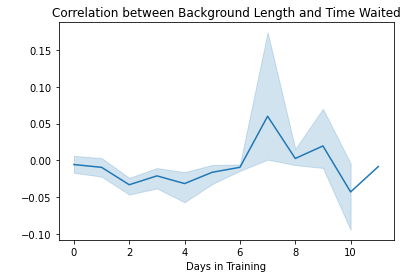

In [73]:
plot_overdays_colored_by_group(data_df=linear_fit_df, 
                               column_name="slope", 
                               plot_name='tb_tw_correlation_by_group', 
                               title='Correlation between Background Length and Time Waited', 
                               x_label='Days in Training', 
                               y_label=' ')

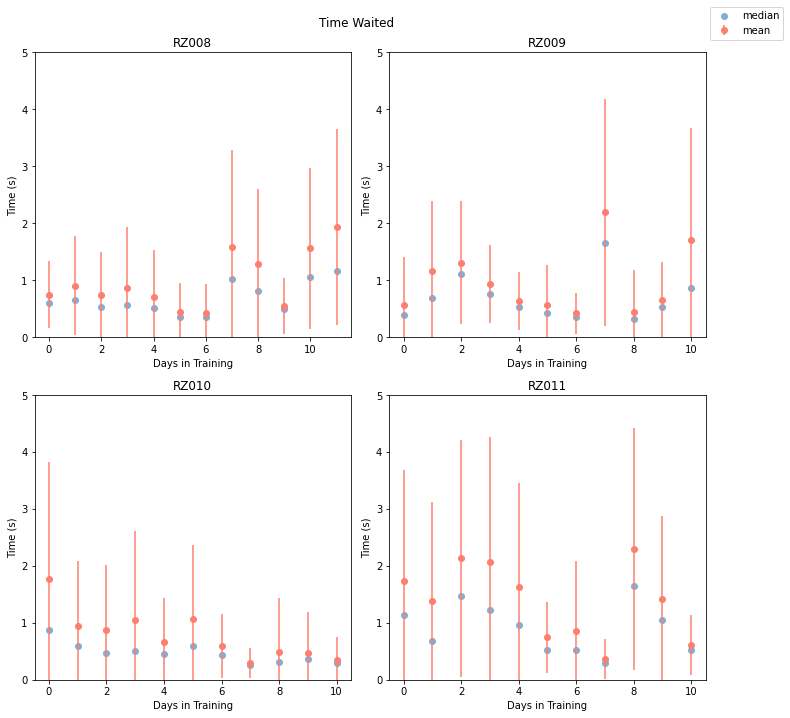

In [98]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.days, session_mouse.tw_mean, session_mouse.tw_stdev, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.days, session_mouse.tw_median, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Time (s)')
    ax.set_ylim(0, 5)

handles, labels = axs[0, 0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
fig.suptitle('Time Waited')

plt.tight_layout()

plt.savefig(f'{figure_folder}/tw_plots.png', bbox_inches='tight', dpi=300)

plt.show()

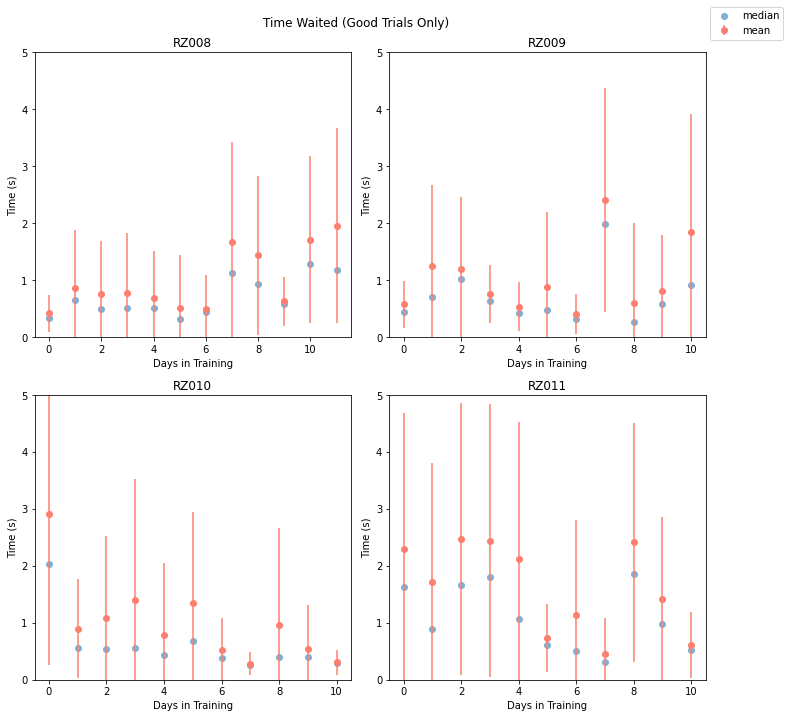

In [100]:
# Create a figure with six subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.days, session_mouse.tw_mean_g, session_mouse.tw_stdev_g, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.days, session_mouse.tw_median_g, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Time (s)')
    ax.set_ylim(0, 5)

# Extract the legend from the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()

# Set the figure legend outside the loop
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
fig.suptitle('Time Waited (Good Trials Only)')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_good_plots.png', bbox_inches='tight', dpi=300)

# Show the plot (optional)
plt.show()

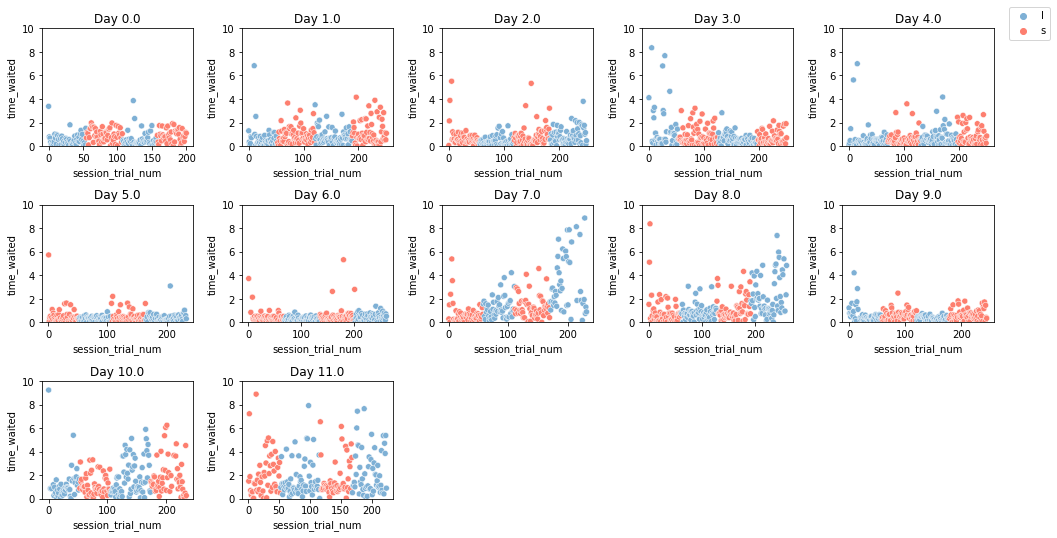

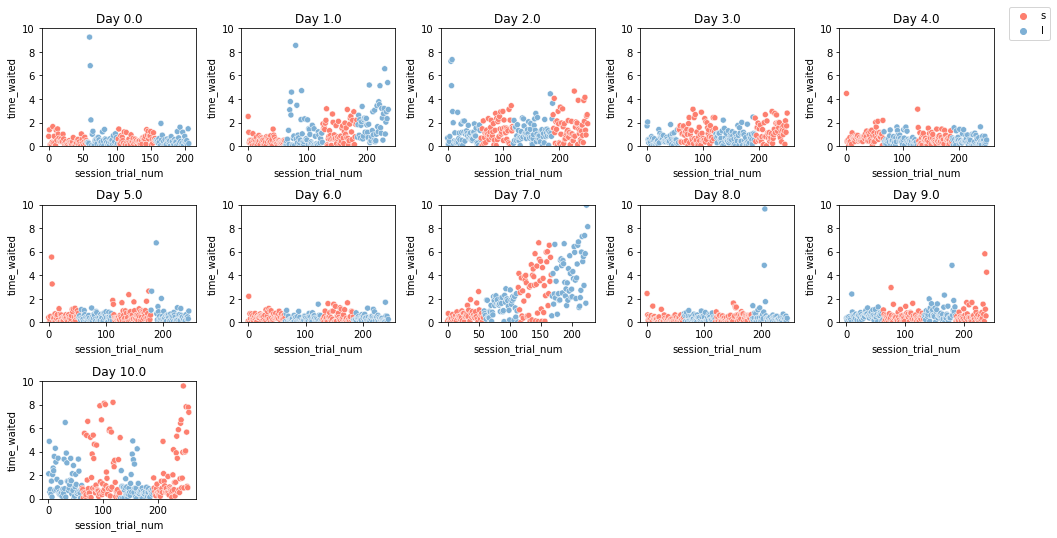

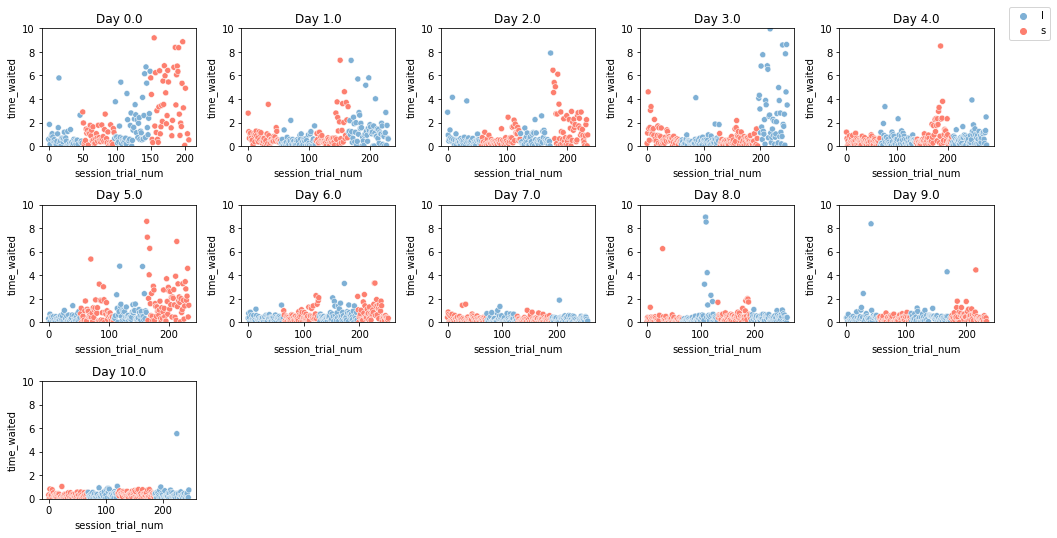

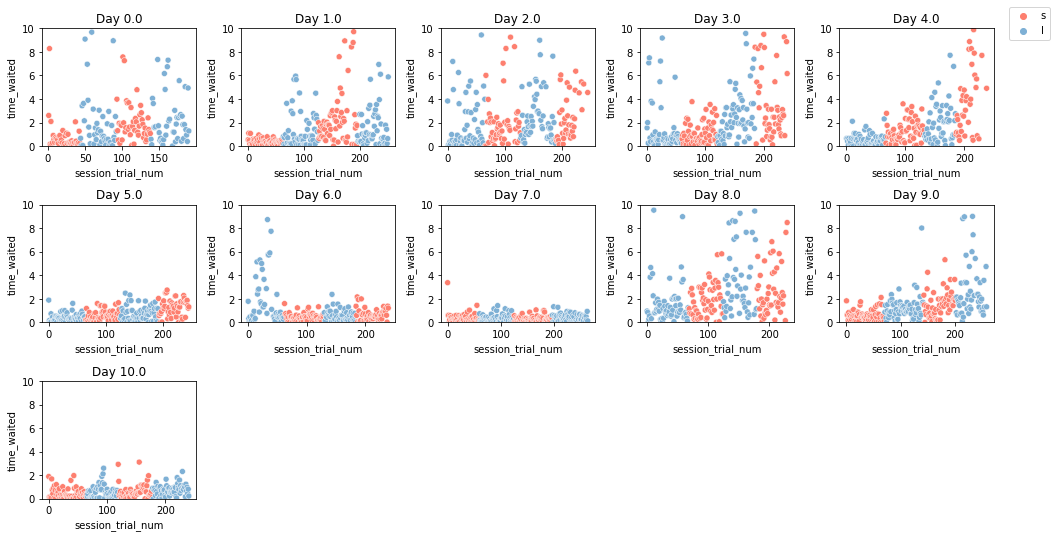

In [76]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Day {day}')
        ax.set_ylim([0, 10])

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)

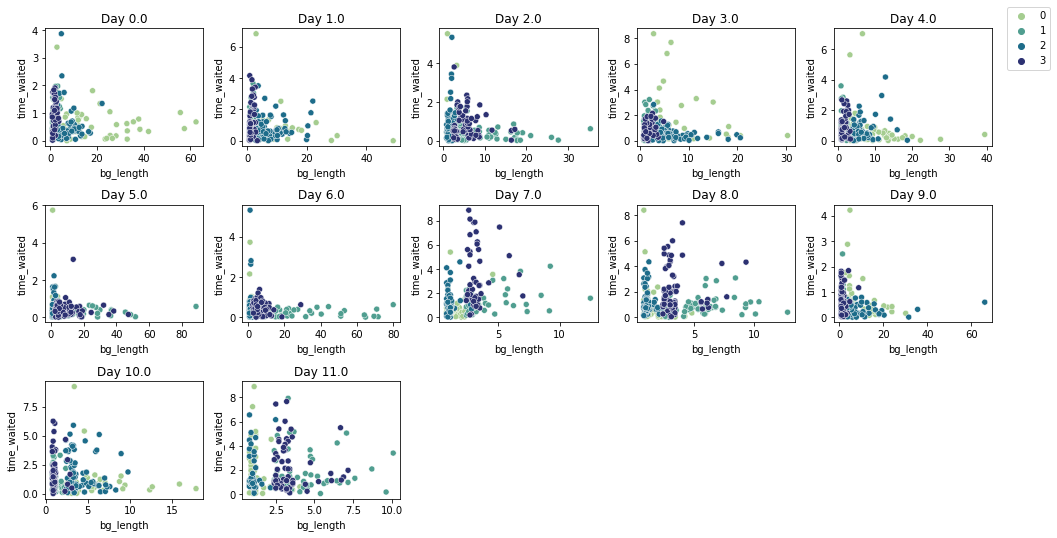

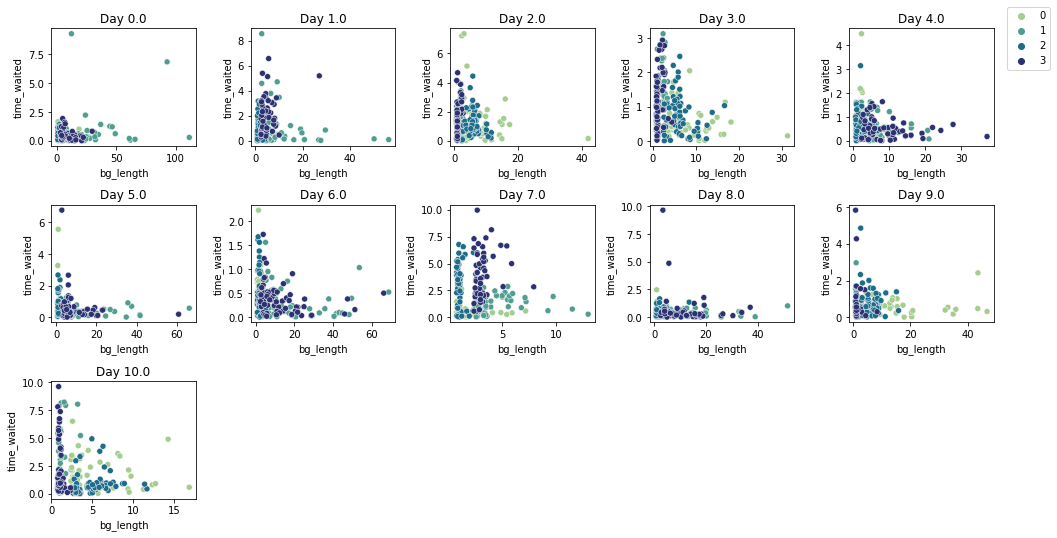

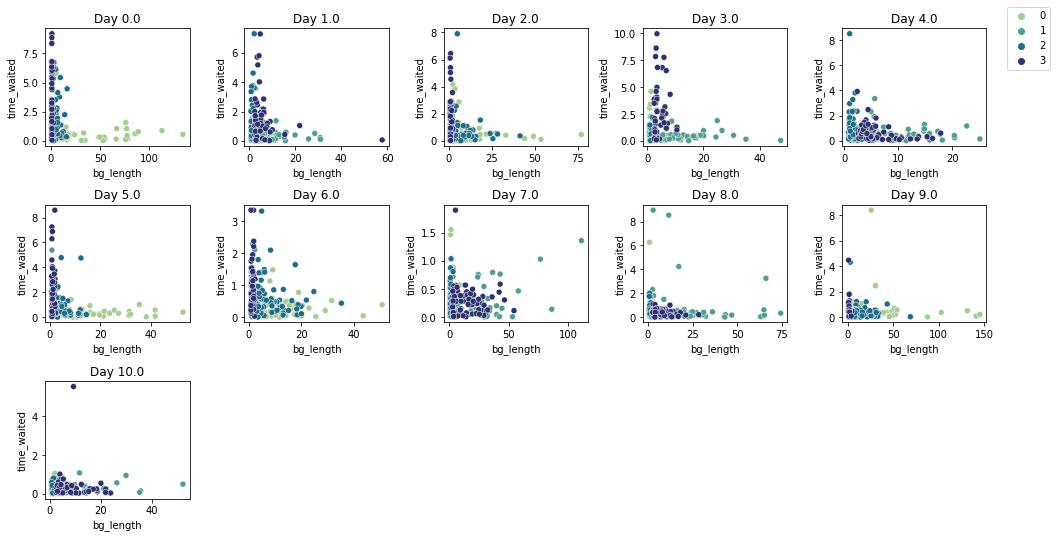

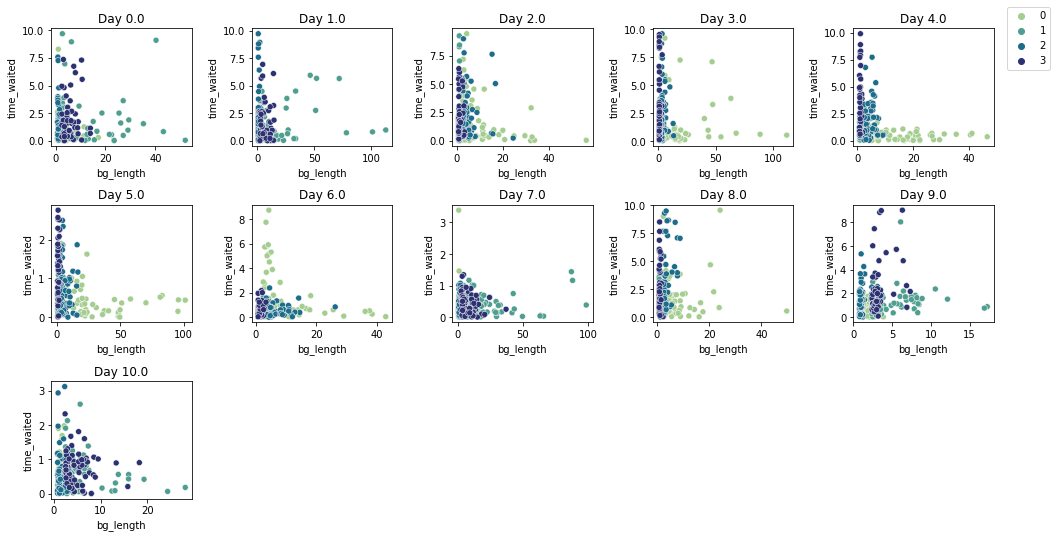

In [77]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
      
        sns.scatterplot(x="bg_length",
                        y="time_waited",
                        hue="block_num",
                        data=all_trials,
                        palette="crest",
                        ax=axs.flat[i])
        ax.set_title(f'Day {day}')
        handles, labels = ax.get_legend_handles_labels()
    
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/bg_vs_tw_blk_{mouse}.png', bbox_inches='tight', dpi=300)


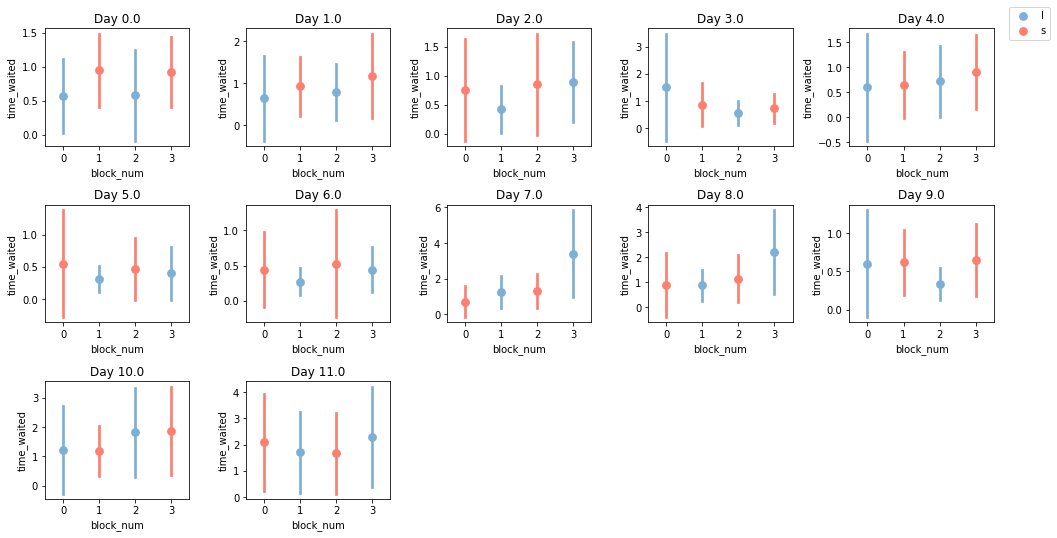

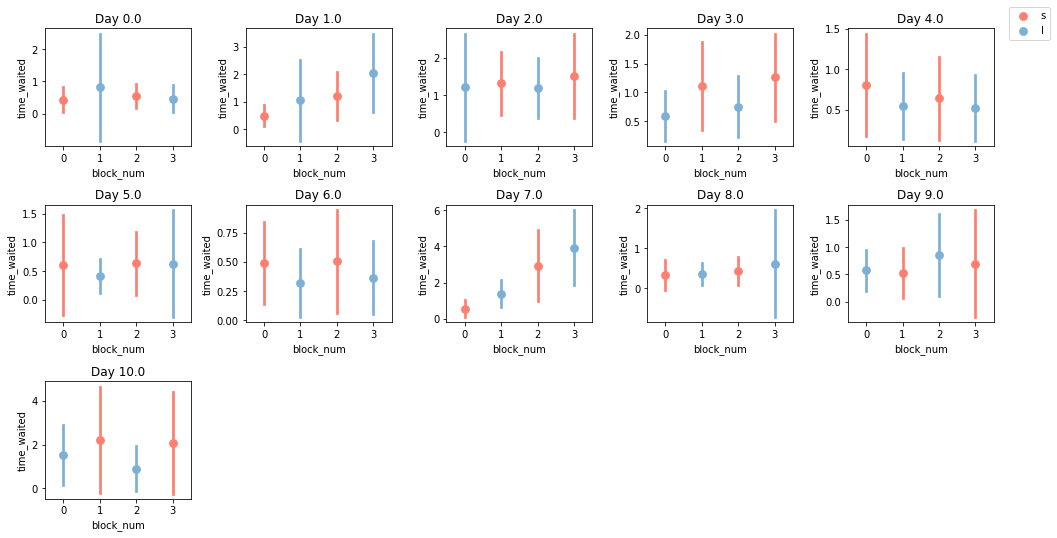

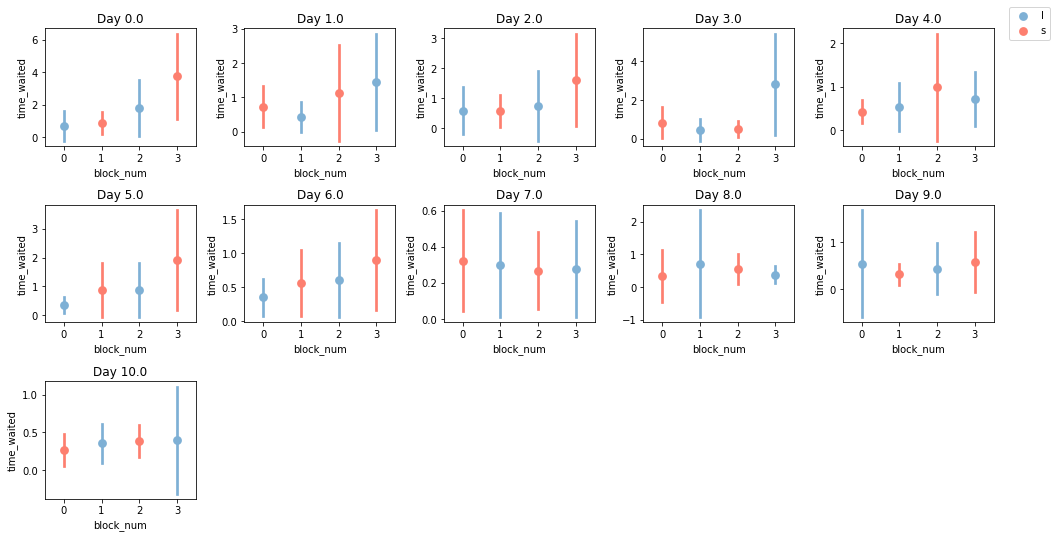

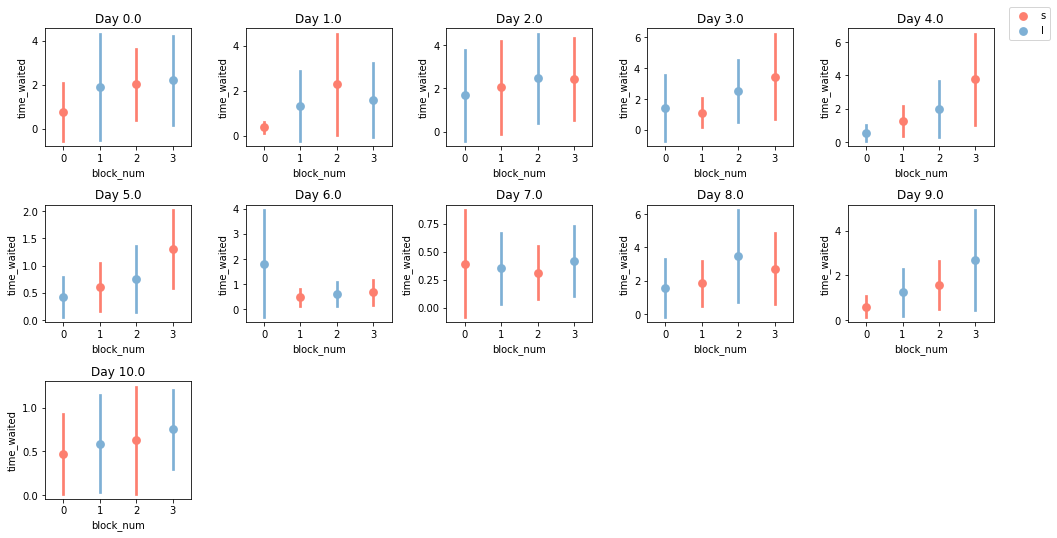

In [78]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]

        sns.pointplot(x="block_num",
                        y="time_waited",
                        errorbar='sd',
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Day {day}')

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_pointplot_{mouse}.png', bbox_inches='tight', dpi=300)

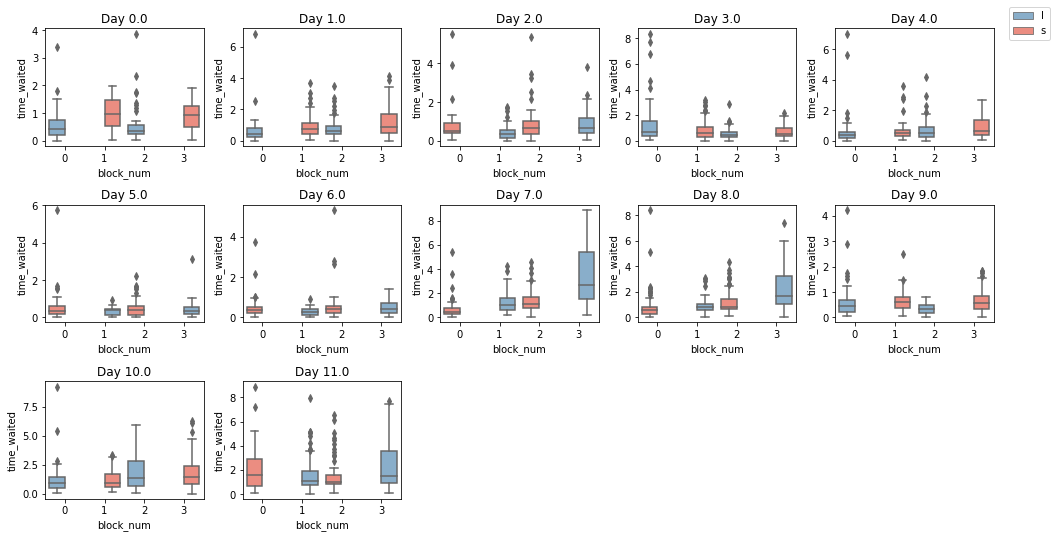

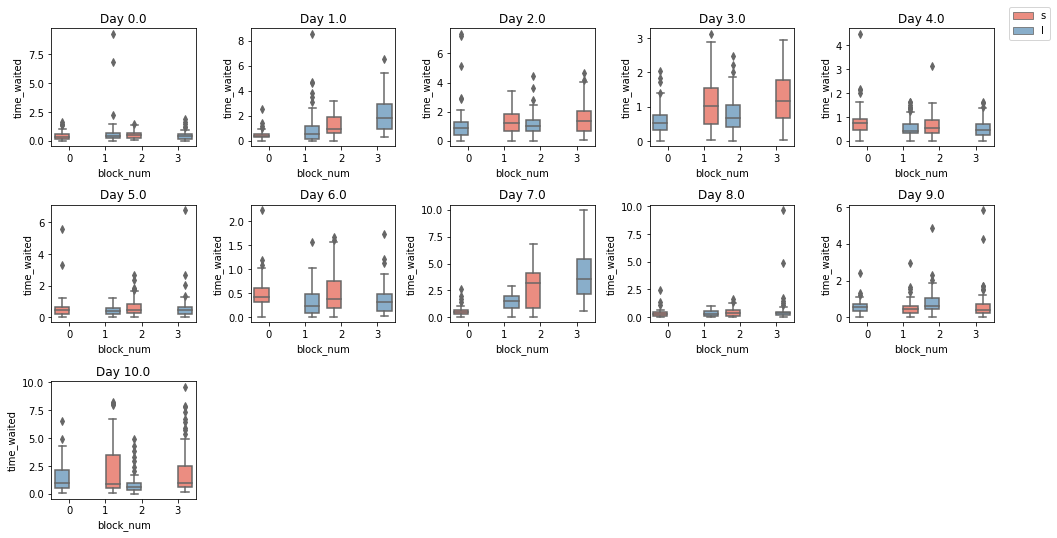

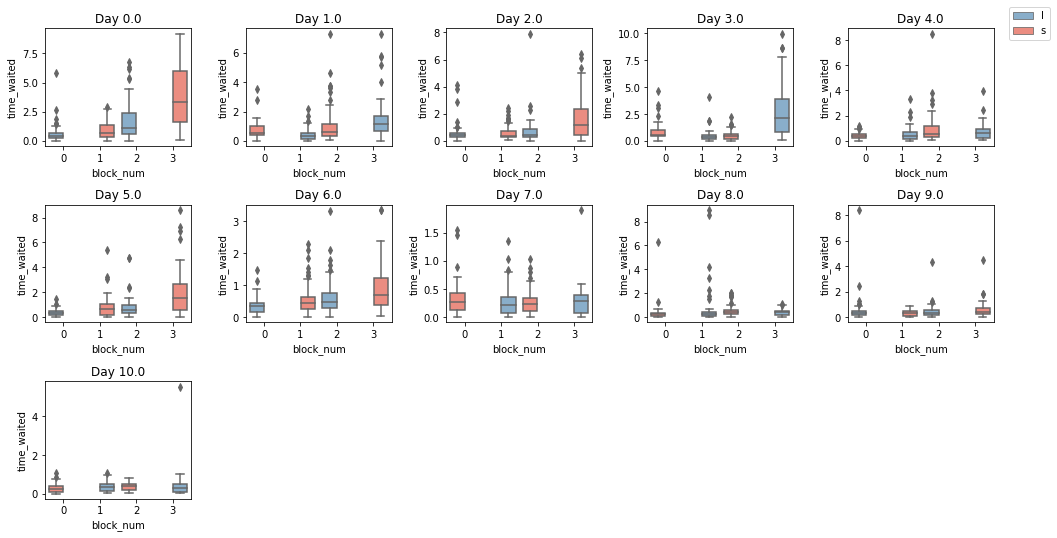

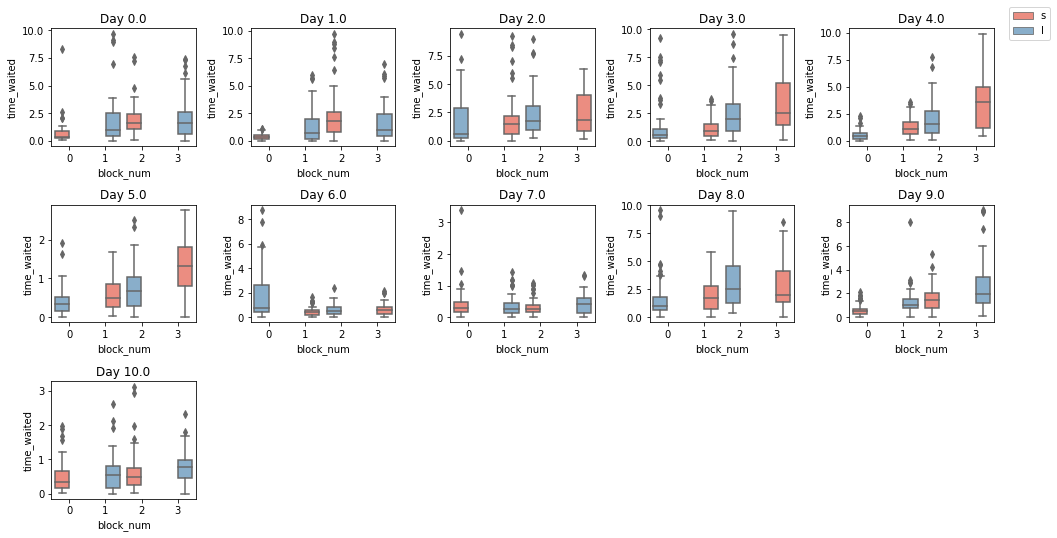

In [79]:
# violin plot but 

for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        sns.boxplot(x="block_num",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Day {day}')

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    # plt.savefig(f'trial_num_vs_tw_violinplot_{mouse}.png', bbox_inches='tight', dpi=300)

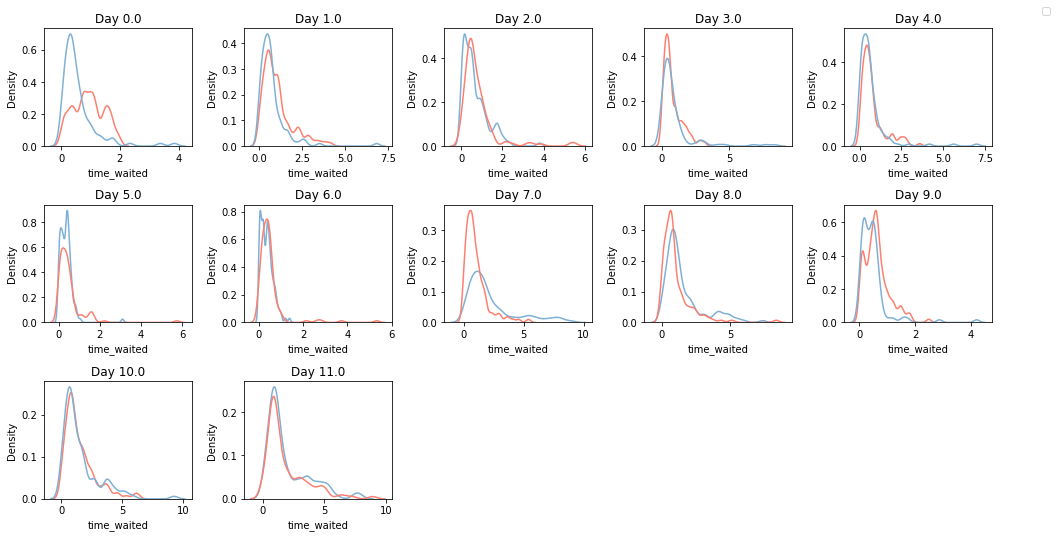

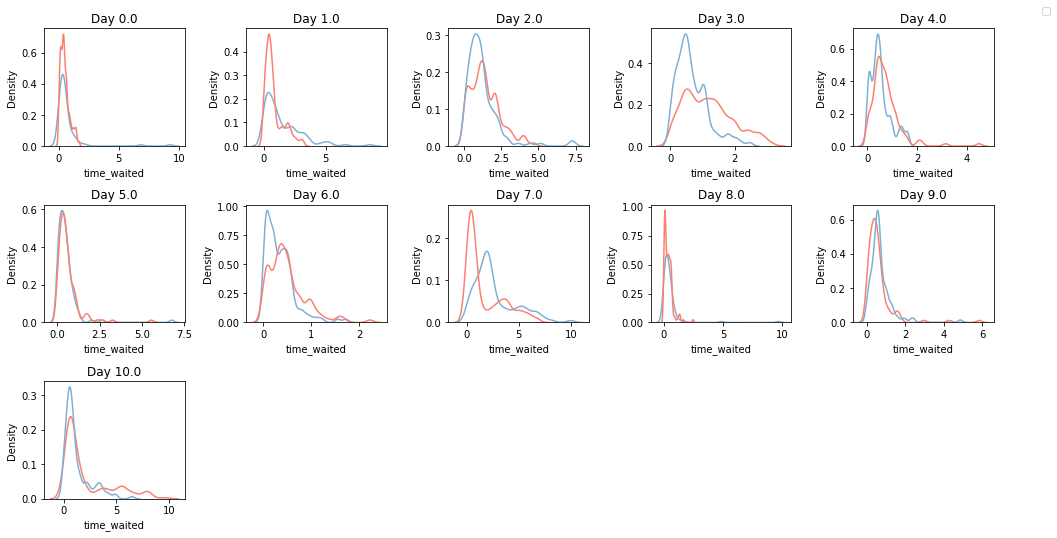

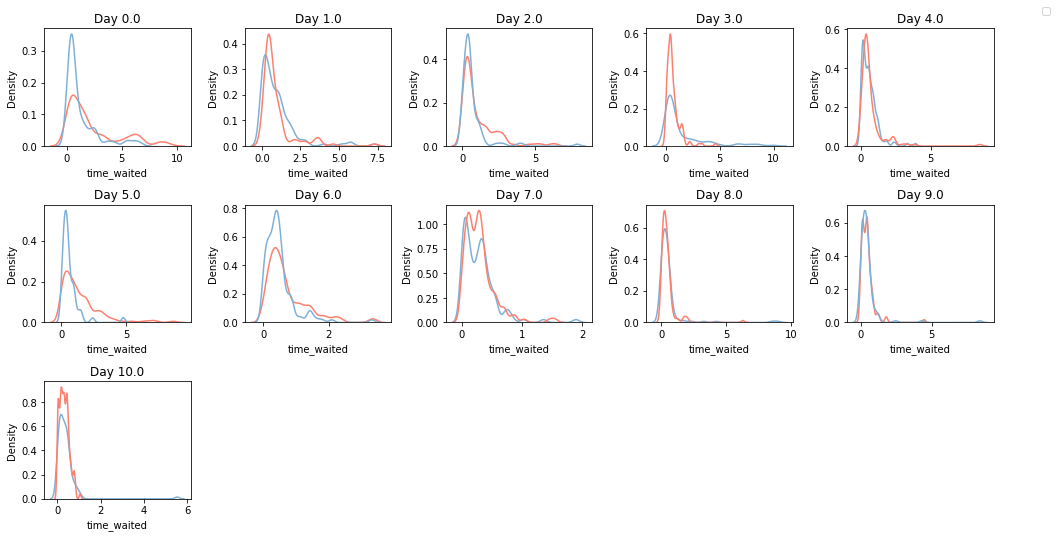

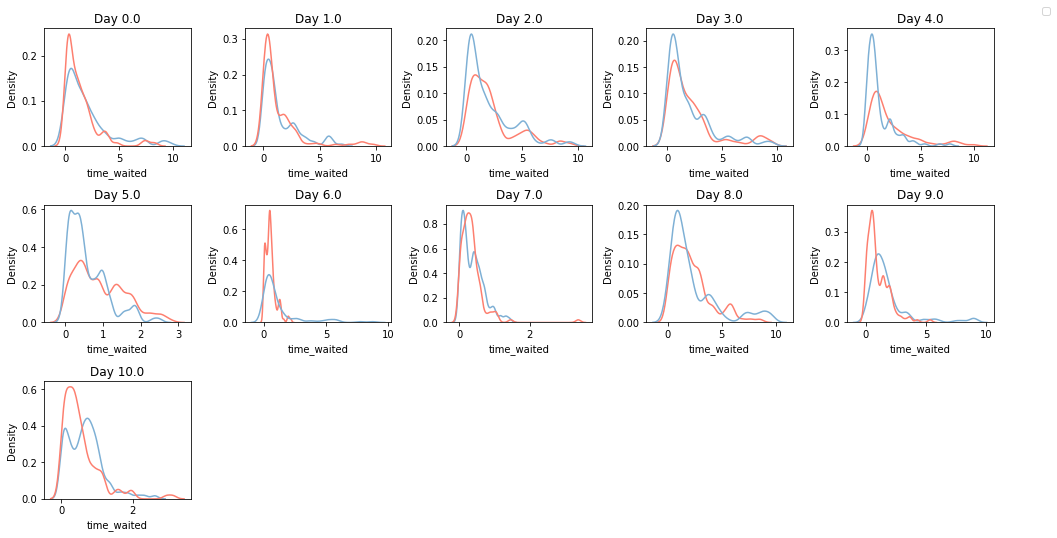

In [80]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]

        sns.kdeplot(data=all_trials, 
                    x="time_waited", 
                    hue="blk_type",
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
        ax.set_title(f'Day {day}')

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/tw_kde_{mouse}.png', bbox_inches='tight', dpi=300)

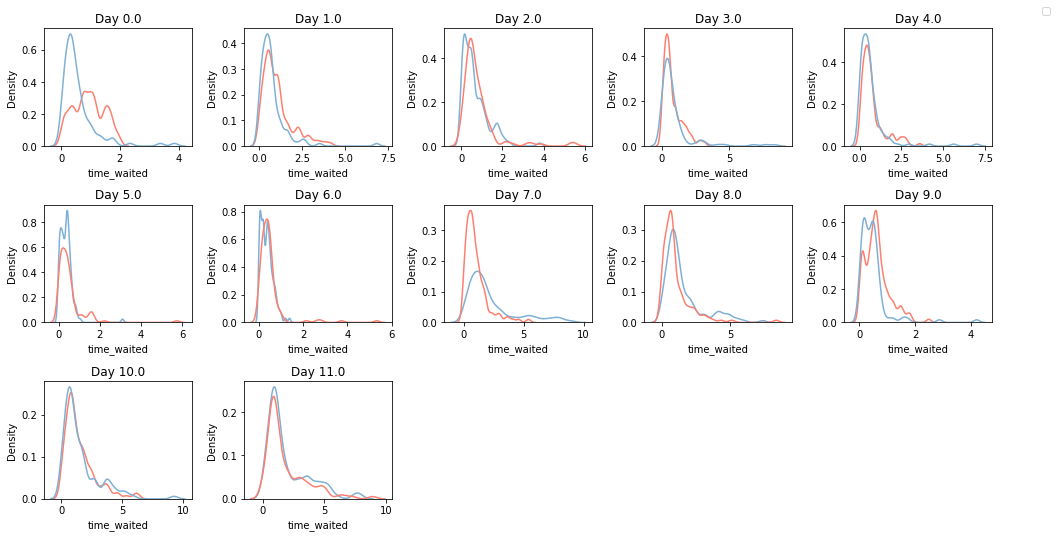

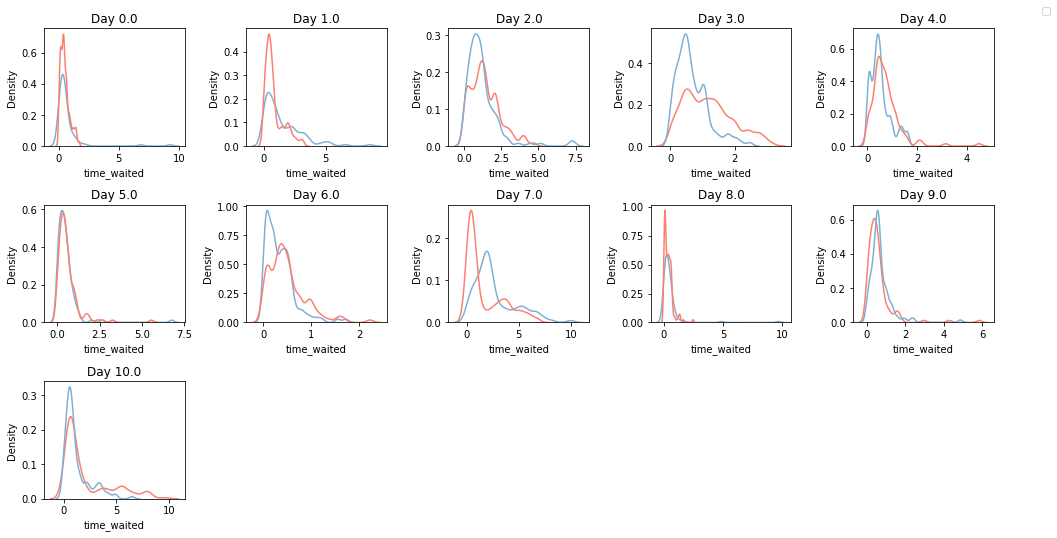

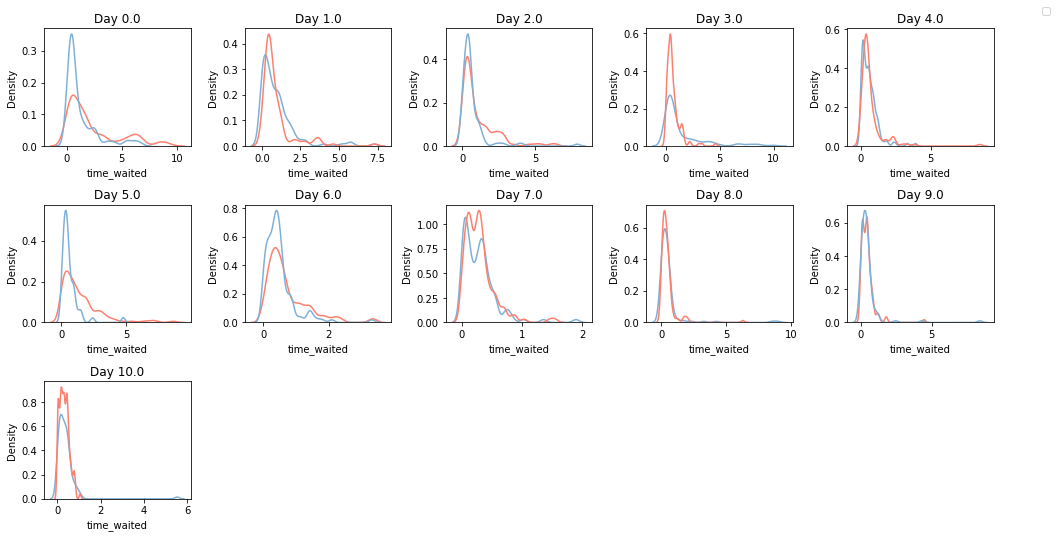

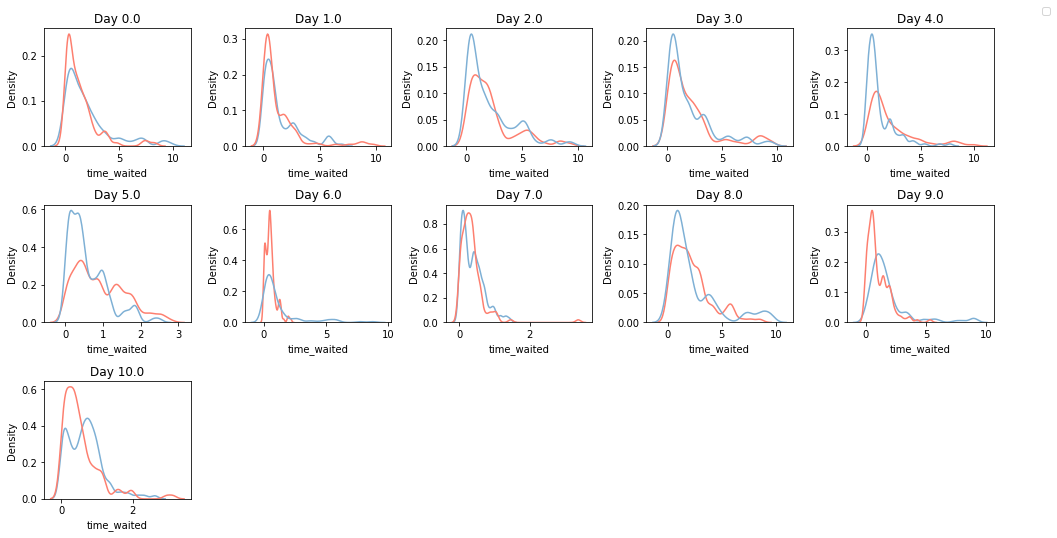

In [81]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, day) in enumerate(zip(session_mouse.dir, session_mouse.days)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        good_trials = select_good_trials(all_trials)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]

        sns.kdeplot(data=all_trials, 
                    x="time_waited", 
                    hue="blk_type", 
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
        ax.set_title(f'Day {day}')

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/tw_kde_g_{mouse}.png', bbox_inches='tight', dpi=300)

# Some stats

In [82]:
import scipy.stats as s_stats

### Check if boys and girls are significantly different

In [83]:
boys =  ['RZ008', 'RZ009']
girls = ['RZ010', 'RZ011']

boy = wait_df['tw_mean'][wait_df['mouse'].isin(boys)]
girl = wait_df['tw_mean'][wait_df['mouse'].isin(girls)]

b_vs_g = s_stats.ttest_ind(boy, girl)

b_vs_g

Ttest_indResult(statistic=-0.6631963341933168, pvalue=0.51074469497928)

### check if mice are different 

In [84]:
s_stats.f_oneway(wait_df['tw_mean'][wait_df['mouse'] == 'RZ008'],
               wait_df['tw_mean'][wait_df['mouse'] == 'RZ009'],
               wait_df['tw_mean'][wait_df['mouse'] == 'RZ010'],
               wait_df['tw_mean'][wait_df['mouse'] == 'RZ011'])

F_onewayResult(statistic=2.4241869391194997, pvalue=0.0794378308315824)

### Check if long and short blocks are significantly different

add p values to the tw diff

In [85]:
for dir_name in training_session_log.dir:
    all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
    all_trials = all_trials[all_trials['time_waited'].notna()]
    long = all_trials['time_waited'][all_trials['blk_type'] == 'l']
    short = all_trials['time_waited'][all_trials['blk_type'] == 's']
    l_v_s = s_stats.ttest_ind(long, short)
    wait_df.loc[wait_df.dir == dir_name, 
                            ['tw_diff_p_val']] = l_v_s[1]
    
    good_trials = select_good_trials(all_trials)
    long = good_trials['time_waited'][good_trials['blk_type'] == 'l']
    short = good_trials['time_waited'][good_trials['blk_type'] == 's']
    l_v_s = s_stats.ttest_ind(long, short)
    wait_df.loc[wait_df.dir == dir_name, 
                            ['tw_diff_g_p_val']] = l_v_s[1]

/var/folders/jf/_0n_zq0x43xgvnjkfyzxmpm40000gn/T/ipykernel_3586/3812826318.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  l_v_s = s_stats.ttest_ind(long, short)
/Users/rebekahzhang/opt/anaconda3/envs/LUCKYCHARM/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/rebekahzhang/opt/anaconda3/envs/LUCKYCHARM/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [86]:
len(wait_df)

45

In [87]:
len(wait_df[wait_df.tw_diff > 0])

22

In [88]:
len(wait_df[wait_df['tw_diff_p_val'] < 0.05])

23

In [89]:
wait_df.loc[(wait_df.tw_diff > 0) & (wait_df.tw_diff_p_val < 0.05)]

,mouse,days,dir,tw_mean,tw_median,tw_stdev,tw_l_mean,tw_l_median,tw_l_stdev,tw_s_mean,...,tw_l_mean_g,tw_l_median_g,tw_l_stdev_g,tw_s_mean_g,tw_s_median_g,tw_s_stdev_g,tw_diff,tw_diff_g,tw_diff_p_val,tw_diff_g_p_val
3,RZ011,0.0,2023-02-27_16-27-06_RZ011,1.738931,1.145989,1.946547,2.053122,1.335979,2.204515,1.414150,...,2.710661,2.149726,2.571797,2.000088,1.219313,2.269091,0.638972,0.710573,2.684696e-02,3.234822e-01
5,RZ009,1.0,2023-02-28_11-58-24_RZ009,1.157973,0.692406,1.237106,1.505102,0.990943,1.526396,0.828058,...,1.822027,1.143312,1.680824,0.682809,0.526838,0.764914,0.677045,1.139217,1.945437e-05,1.306220e-03
14,RZ010,3.0,2023-03-02_14-01-33_RZ010,1.043253,0.498198,1.574437,1.469102,0.528234,2.099347,0.657019,...,2.453310,0.977352,2.830486,0.613944,0.417890,0.744750,0.812083,1.839367,4.178309e-05,1.120618e-04
27,RZ008,7.0,2023-03-08_11-13-31_RZ008,1.588809,1.028235,1.689503,2.256219,1.577108,2.075806,1.019210,...,2.228586,1.463829,2.185140,1.160381,0.929975,0.975494,1.237009,1.068205,3.295375e-08,1.369630e-04
28,RZ009,7.0,2023-03-08_11-48-10_RZ009,2.192282,1.650023,1.989554,2.687466,2.090060,2.022467,1.697098,...,2.703467,2.117300,2.057063,2.066881,1.292745,1.807257,0.990368,0.636586,1.511027e-04,4.621345e-02
30,RZ011,6.0,2023-03-08_14-08-36_RZ011,0.859293,0.514598,1.220350,1.209307,0.601805,1.661717,0.551619,...,3.205681,2.769290,2.325902,0.457574,0.436367,0.432989,0.657688,2.748107,3.062070e-05,3.611348e-08
31,RZ008,8.0,2023-03-10_09-45-27_RZ008,1.287796,0.814096,1.314439,1.535231,1.021601,1.425074,1.024524,...,1.722171,1.170670,1.520211,1.185037,0.798231,1.240845,0.510707,0.537135,1.690349e-03,1.530182e-02
40,RZ011,9.0,2023-03-16_15-28-31_RZ011,1.415042,1.046370,1.458451,1.822844,1.326375,1.779607,1.035256,...,1.728056,1.168482,1.774367,1.108782,0.814757,0.945109,0.787588,0.619274,1.296319e-05,7.243320e-03


In [90]:
wait_df.loc[(wait_df.tw_diff_g > 0) & (wait_df.tw_diff_g_p_val < 0.05)]

,mouse,days,dir,tw_mean,tw_median,tw_stdev,tw_l_mean,tw_l_median,tw_l_stdev,tw_s_mean,...,tw_l_mean_g,tw_l_median_g,tw_l_stdev_g,tw_s_mean_g,tw_s_median_g,tw_s_stdev_g,tw_diff,tw_diff_g,tw_diff_p_val,tw_diff_g_p_val
4,RZ008,1.0,2023-02-28_11-13-57_RZ008,0.899784,0.645593,0.866113,0.735379,0.555570,0.831763,1.046618,...,1.847185,0.785718,2.813296,0.784697,0.630433,0.658828,-0.311239,1.062488,4.517010e-03,2.161566e-02
5,RZ009,1.0,2023-02-28_11-58-24_RZ009,1.157973,0.692406,1.237106,1.505102,0.990943,1.526396,0.828058,...,1.822027,1.143312,1.680824,0.682809,0.526838,0.764914,0.677045,1.139217,1.945437e-05,1.306220e-03
12,RZ008,3.0,2023-03-02_11-39-52_RZ008,0.866676,0.571969,1.063018,0.932322,0.571126,1.355909,0.805718,...,1.810769,0.819816,2.816150,0.657182,0.498809,0.574988,0.126604,1.153587,3.546606e-01,2.752787e-03
14,RZ010,3.0,2023-03-02_14-01-33_RZ010,1.043253,0.498198,1.574437,1.469102,0.528234,2.099347,0.657019,...,2.453310,0.977352,2.830486,0.613944,0.417890,0.744750,0.812083,1.839367,4.178309e-05,1.120618e-04
16,RZ008,4.0,2023-03-03_10-52-18_RZ008,0.707573,0.503464,0.821053,0.657490,0.473727,0.907843,0.766003,...,1.443022,0.526216,2.342506,0.628678,0.497737,0.582931,-0.108513,0.814345,3.013967e-01,3.353273e-02
27,RZ008,7.0,2023-03-08_11-13-31_RZ008,1.588809,1.028235,1.689503,2.256219,1.577108,2.075806,1.019210,...,2.228586,1.463829,2.185140,1.160381,0.929975,0.975494,1.237009,1.068205,3.295375e-08,1.369630e-04
28,RZ009,7.0,2023-03-08_11-48-10_RZ009,2.192282,1.650023,1.989554,2.687466,2.090060,2.022467,1.697098,...,2.703467,2.117300,2.057063,2.066881,1.292745,1.807257,0.990368,0.636586,1.511027e-04,4.621345e-02
30,RZ011,6.0,2023-03-08_14-08-36_RZ011,0.859293,0.514598,1.220350,1.209307,0.601805,1.661717,0.551619,...,3.205681,2.769290,2.325902,0.457574,0.436367,0.432989,0.657688,2.748107,3.062070e-05,3.611348e-08
31,RZ008,8.0,2023-03-10_09-45-27_RZ008,1.287796,0.814096,1.314439,1.535231,1.021601,1.425074,1.024524,...,1.722171,1.170670,1.520211,1.185037,0.798231,1.240845,0.510707,0.537135,1.690349e-03,1.530182e-02
34,RZ009,8.0,2023-03-15_13-53-21_RZ009,0.435633,0.318564,0.736415,0.496106,0.321921,0.996428,0.380786,...,4.918088,4.918088,6.688980,0.398741,0.261696,0.421302,0.115321,4.519346,2.206765e-01,6.458708e-07
